# Pilot Topic Survey
## Imports and Constants

In [99]:
# Analytical Tools
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy import stats

# Utilities
import math
import json
import literals.question_survey as literals
from tools.utilities import head

%matplotlib inline
%load_ext pycodestyle_magic
%config InlineBackend.figure_format = 'retina'

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [100]:
LOCATION = '../private/output/question-survey-entries.json'
Q_TEXT = literals.question_text
QUESTIONS = {ques: 'q' + str(num) for num, ques in enumerate(Q_TEXT)}
CODES = {'q' + str(num): ques for num, ques in enumerate(Q_TEXT)}

J_TEXT = literals.judgement_text
JUDGEMENTS = {judge: 'j' + str(num) for num, judge in enumerate(J_TEXT)}

## Reading in Data
Open the file containing all the data and reads it in line by line. Notice we are only interested in reponses past 30, since this is when we significantly changed the survey.

In [101]:
with open(LOCATION) as file:
    master_list = [json.loads(line) for line in file if line]
updated_responses = master_list[30:]
len(master_list), len(updated_responses)
updated_responses[0]['data'][11]

{'condition': 'highA',
 'internal_node_id': '0.0-2.0-9.0',
 'questionScores': [['Why does the eastern half of the United States have colder winters than the western half?',
   29],
  ['How do activated carbon filters work?', 3361],
  ['Why must a country "declare war" before attacking?', 3364],
  ["Why do you feel sick and not hungry when you haven't eaten?", 3381],
  ['What are the biological advantages and disadvantages of trees shedding their leaves vs keeping them all year round (deciduous vs coniferous)?',
   14],
  ["How does sleep restore the body's energy?", 3377],
  ['Why waves? All energy transfer in nature from one point to another happens in waves. Light, sound, even gravity travels in waves. Which fundamental property of nature is responsible for wave-like nature? Are there other non-wave-like ways to transfer energy from one point to another?',
   3362],
  ['Why are bubbles round?', 36],
  ['How do such small doses of things like cocaine and heroin kill you? How do these 

## Processing the data
Creates a dictionary for each of the columns and updates each series once per person, hence populating the data from the raw json into a csv to be analyzed. Notice 

In [102]:
# Create dictionary to represent future DataFrame
def get_col_labels(question_num, judgement_num):
    """
    :param question_num: (int) the number of question
    :param judgement_num: (int) the number fo responses
    :return: [str] a strings of label for the columns
    """
    labels = ['condition', 'consent']
    for q_num in range(question_num):
        labels.append('q' + str(q_num) + 'score')
        for j_num in range(judgement_num):
            labels.append('q' + str(q_num) + 'j' + str(j_num))
    return labels


col_labels = get_col_labels(len(QUESTIONS), len(JUDGEMENTS))
data = {label: [] for label in col_labels}

In [103]:
# Populate dictionary with the data
for person in updated_responses:
    responses = person['data']
    consent = responses[0]
    # Add condition to data
    data['condition'].append(consent['condition'][-1])
    # Resolve question order, adding scores to the data kept
    question_order = []
    for text, score in consent['questionScores']:
        question_label = QUESTIONS[text]
        question_order.append(question_label)
        data[question_label + 'score'].append(score)
    # Resolve jugement order
    judgements_order = []
    for judge in consent['randomJudgements']:
        judgements_order.append(JUDGEMENTS[judge])
    # Add consent responses
    consent_response = json.loads(consent['responses'])
    consent_response = int(consent_response['Q0'].startswith('I consent'))
    data['consent'].append(consent_response)
    # Add likert responses
    col_names = (ques_num + judge_num for ques_num, judge_num in
                 itertools.product(question_order, judgements_order))
    for question_index in range(2, 12):
        question_data = responses[question_index]
        question_responses = json.loads(question_data['responses'])
        for sorted_label in sorted(question_responses):
            data[next(col_names)].append(int(question_responses[sorted_label]))

pilot = pd.DataFrame(data)
pilot.head()

,condition,consent,q0j0,q0j1,q0j2,q0j3,q0j4,q0score,q1j0,q1j1,...,q8j2,q8j3,q8j4,q8score,q9j0,q9j1,q9j2,q9j3,q9j4,q9score
0,A,1,3,3,2,4,4,3381,4,3,...,3,2,2,32,4,3,4,3,3,29
1,A,1,4,4,2,5,2,3362,4,4,...,4,4,2,32,5,0,5,4,2,32
2,A,1,1,4,4,3,4,3365,2,4,...,4,3,3,37,5,2,5,4,4,26
3,A,1,2,1,1,2,1,3370,2,2,...,3,2,3,53,3,2,1,2,2,36
4,A,1,1,0,5,2,5,3370,3,4,...,5,4,0,23,4,2,6,5,0,29


## Analysizing Data
We fist split the data into two groups, one corresponding to those which received high scores for group A and one for those who received higher scores for group B. The groups themselves are in the constant section for reference, where the first five entries corresponding to group A and the last five to group B.

In [104]:
pilot = pilot[pilot.consent == 1]
high_a = pilot[pilot.condition == 'A']
high_b = pilot[pilot.condition == 'B']
a_size = len(high_a)
b_size = len(high_b)

In [105]:
%%pycodestyle
# Score plots
fig, ax = plt.subplots()

labels = [label + 'score' for label in QUESTIONS.values()]
ind, width = np.arange(len(labels)), 0.35

a_means = [high_a[column].mean() for column in labels]
a_stds = [high_a[column].std() / math.sqrt(a_size) for column in labels]
a_rects = ax.bar(ind, a_means, width, yerr=a_stds)

b_means = [high_b[column].mean() for column in labels]
b_stds = [high_b[column].std() / math.sqrt(b_size) for column in labels]
b_rects = ax.bar(ind + width, b_means, width, yerr=b_stds)

ax.set_xticks(ind + width / 2)
ax.set_xticklabels([word[:2] for word in labels])

fig.set_size_inches(10, 5)
plt.title('Scores under Different Conditions')
plt.legend(['High A Condition', 'High B Condition'])
plt.show()

# Compare Question Means
for ques in sorted(QUESTIONS.values()):
    fig, ax = plt.subplots()

    labels = [ques + judge for judge in JUDGEMENTS.values()]
    ind, width = np.arange(len(labels)), 0.35

    a_means = [high_a[column].mean() for column in labels]
    a_stds = [high_a[column].std() / math.sqrt(a_size) for column in labels]
    a_rects = ax.bar(ind, a_means, width, yerr=a_stds)

    b_means = [high_b[column].mean() for column in labels]
    b_stds = [high_b[column].std() / math.sqrt(b_size) for column in labels]
    b_rects = ax.bar(ind + width, b_means, width, yerr=b_stds)
    
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(labels)

    # fig.set_size_inches(10, 5)
    plt.legend(['High A Scores', 'High B Scores'])
    plt.show()

37:1: W293 blank line contains whitespace


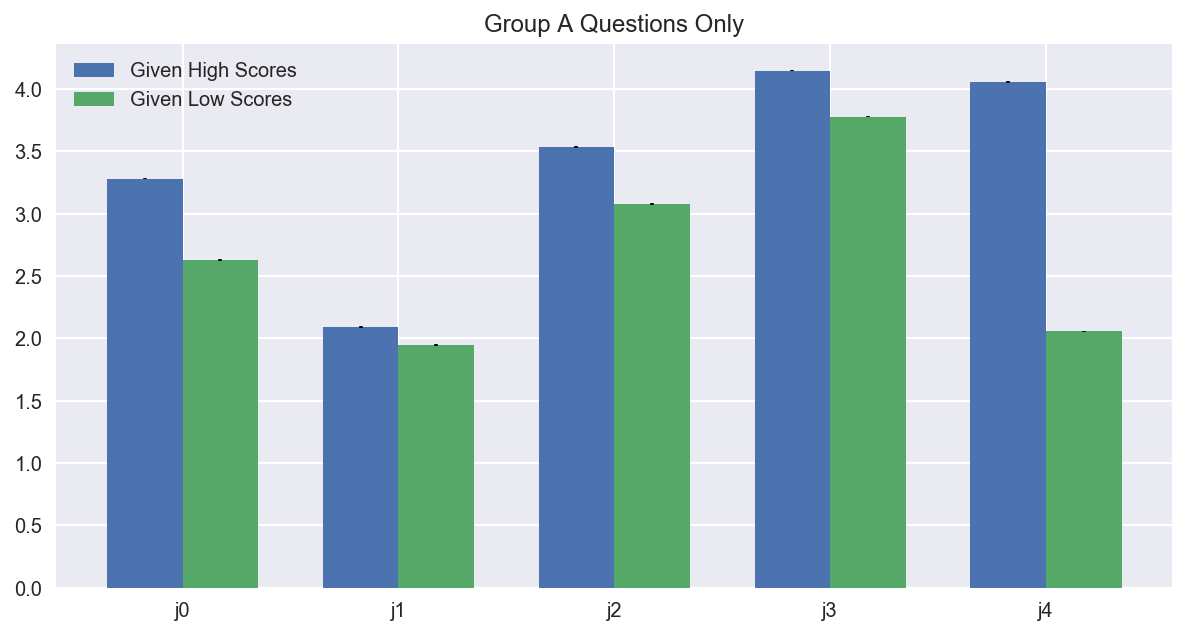

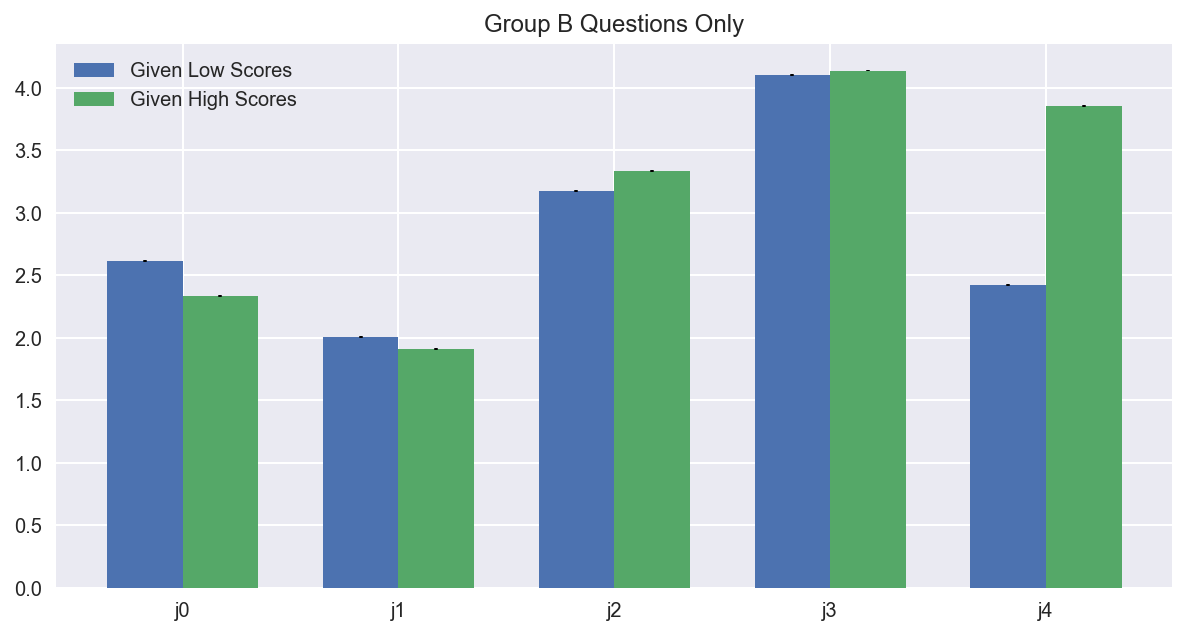

In [106]:
group_a = list(QUESTIONS.values())[:5]
group_b = list(QUESTIONS.values())[5:]
labels = list(JUDGEMENTS.values())

# Comparison of group A questions under both conditions

a_means = []
a_stds = []
group_a_high_a = []
for judge in labels:
    a_series = []
    for ques in group_a:
        a_series.append(high_a[ques + judge])
    a_series = pd.concat(a_series)
    group_a_high_a.append(a_series)
    a_means.append(a_series.mean())
    a_stds.append(a_series.std() / len(a_series))

b_means = []
b_stds = []
group_a_high_b = []
for judge in labels:
    b_series = []
    for ques in group_a:
        b_series.append(high_b[ques + judge])
    b_series = pd.concat(b_series)
    group_a_high_b.append(b_series)
    b_means.append(b_series.mean())
    b_stds.append(b_series.std() / len(b_series))

fig, ax = plt.subplots()
ind, width = np.arange(len(labels)), 0.35

a_rects = ax.bar(ind, a_means, width, yerr=a_stds)
b_rects = ax.bar(ind + width, b_means, width, yerr=b_stds)

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(labels)

fig.set_size_inches(10, 5)
plt.title('Group A Questions Only')
plt.legend(['Given High Scores', 'Given Low Scores'])
plt.show()

# Comparison of group B questions under both conditions

a_means = []
a_stds = []
group_b_high_a = []
for judge in labels:
    a_series = []
    for ques in group_b:
        a_series.append(high_a[ques + judge])
    a_series = pd.concat(a_series)
    group_b_high_a.append(a_series)
    a_means.append(a_series.mean())
    a_stds.append(a_series.std() / len(a_series))

b_means = []
b_stds = []
group_b_high_b = []
for judge in labels:
    b_series = []
    for ques in group_b:
        b_series.append(high_b[ques + judge])
    b_series = pd.concat(b_series)
    group_b_high_b.append(b_series)
    b_means.append(b_series.mean())
    b_stds.append(b_series.std() / len(b_series))

fig, ax = plt.subplots()
ind, width = np.arange(len(labels)), 0.35

a_rects = ax.bar(ind, a_means, width, yerr=a_stds)
b_rects = ax.bar(ind + width, b_means, width, yerr=b_stds)

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(labels)

fig.set_size_inches(10, 5)
plt.title('Group B Questions Only')
plt.legend(['Given Low Scores', 'Given High Scores'])
plt.show()

In [107]:
# Runs the statisical tests
print('Group A')
for match, opposite, label in zip(group_a_high_a, group_a_high_b, labels):
    t, prob = scipy.stats.ttest_ind(match, opposite)
    winner = 'high a' if match.mean() > opposite.mean() else 'high b'
    print('{}: t = {}, p = {} ({} greater)'.format(label, t, prob, winner))

print('Group B')
for opposite, match, label in zip(group_b_high_a, group_b_high_b, labels):
    t, prob = scipy.stats.ttest_ind(match, opposite)
    winner = 'high b' if match.mean() > opposite.mean() else 'high a'
    print('{}: t = {}, p = {} ({} greater)'.format(label, t, prob, winner))

Group A
j0: t = 4.161038961135948, p = 3.7320284228886367e-05 (high a greater)
j1: t = 0.9121472318922004, p = 0.36213255508197306 (high a greater)
j2: t = 2.7290918486893463, p = 0.006575590986877744 (high a greater)
j3: t = 2.799498023718503, p = 0.005316909083473428 (high a greater)
j4: t = 14.470220346450697, p = 7.258910492359169e-40 (high a greater)
Group B
j0: t = -1.8083774627312255, p = 0.07115083151678021 (high a greater)
j1: t = -0.5447296131653382, p = 0.5861833354347368 (high a greater)
j2: t = 0.9497968335251622, p = 0.34267619285597284 (high b greater)
j3: t = 0.27797159947732747, p = 0.781149526963359 (high b greater)
j4: t = 8.893941195710052, p = 1.0902126700095111e-17 (high b greater)


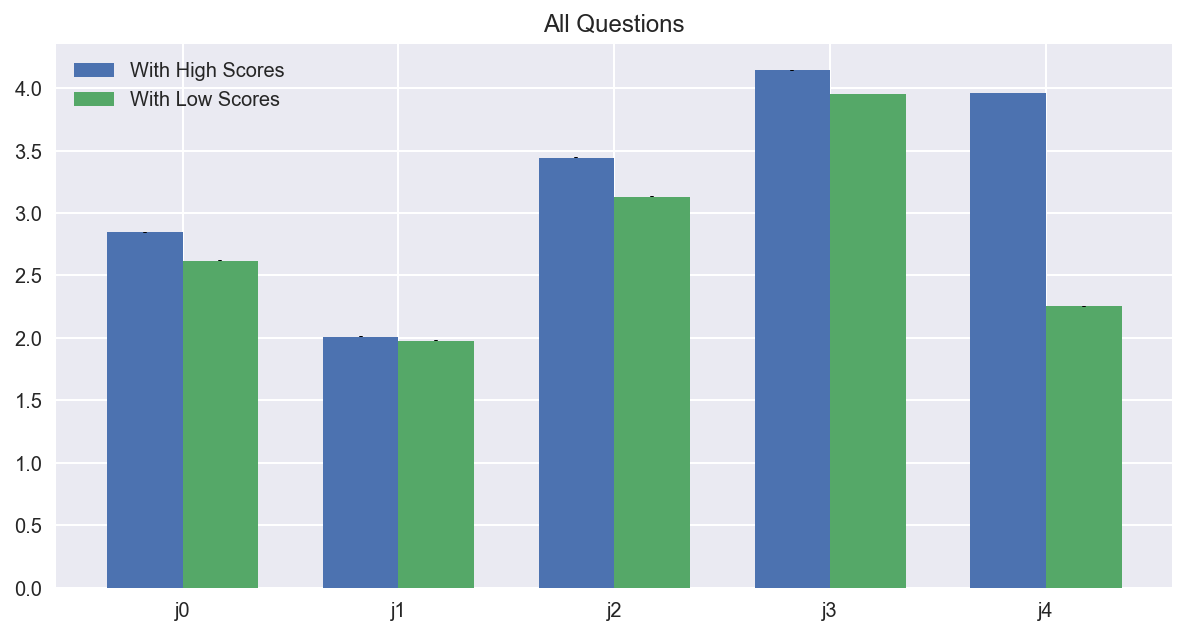

In [108]:
labels = list(JUDGEMENTS.values())

# Compares all matching to all non-matching
match_means = []
match_stds = []
matching_ratings = []
for judge in labels:
    a_series = []
    for ques in group_a:
        a_series.append(high_a[ques + judge])
    for ques in group_b:
        a_series.append(high_b[ques + judge])
    a_series = pd.concat(a_series)
    matching_ratings.append(a_series)
    match_means.append(a_series.mean())
    match_stds.append(a_series.std() / len(a_series))

opposite_means = []
opposite_stds = []
opposite_ratings = []
for judge in labels:
    b_series = []
    for ques in group_a:
        b_series.append(high_b[ques + judge])
    for ques in group_b:
        b_series.append(high_a[ques + judge])
    b_series = pd.concat(b_series)
    opposite_ratings.append(b_series)
    opposite_means.append(b_series.mean())
    opposite_stds.append(b_series.std() / len(b_series))


fig, ax = plt.subplots()
ind, width = np.arange(len(labels)), 0.35

a_rects = ax.bar(ind, match_means, width, yerr=match_stds)
b_rects = ax.bar(ind + width, opposite_means, width, yerr=opposite_stds)

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(labels)

fig.set_size_inches(10, 5)
plt.title('All Questions')
plt.legend(['With High Scores', 'With Low Scores'])
plt.show()

In [109]:
# Runs the statisical tests
for match, opposite, label in zip(matching_ratings, opposite_ratings, labels):
    t, prob = scipy.stats.ttest_ind(match, opposite)
    winner = 'higher' if match.mean() > opposite.mean() else 'lower'
    print('{}: t = {}, p = {} ({} greater)'.format(label, t, prob, winner))

j0: t = 2.0181105729498885, p = 0.04384690829071165 (higher greater)
j1: t = 0.292520690256839, p = 0.7699493456887071 (higher greater)
j2: t = 2.630218162051123, p = 0.008664392505527049 (higher greater)
j3: t = 2.0721931338232937, p = 0.03850377690418222 (higher greater)
j4: t = 16.119999961375292, p = 3.923267576093897e-52 (higher greater)


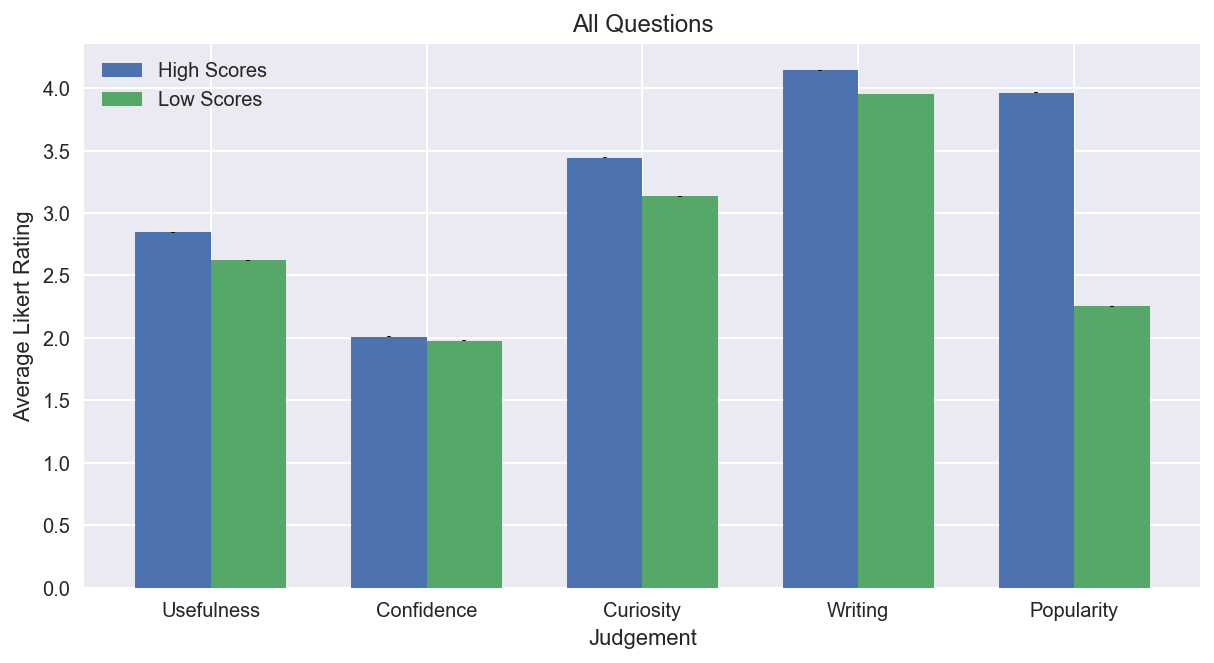

In [128]:
labels = list(JUDGEMENTS.values())
ticks = ['Usefulness', 'Confidence', 'Curiosity', 'Writing', 'Popularity']
legend = ['High Scores', 'Low Scores']
x_label = 'Judgement'
y_label = 'Average Likert Rating'
title = 'All Questions'

# Overall Comparisons
match_means = []
match_stds = []
matching_ratings = []
for judge in labels:
    a_series = []
    for ques in group_a:
        a_series.append(high_a[ques + judge])
    for ques in group_b:
        a_series.append(high_b[ques + judge])
    a_series = pd.concat(a_series)
    matching_ratings.append(a_series)
    match_means.append(a_series.mean())
    match_stds.append(a_series.std() / len(a_series))

opposite_means = []
opposite_stds = []
opposite_ratings = []
for judge in labels:
    b_series = []
    for ques in group_a:
        b_series.append(high_b[ques + judge])
    for ques in group_b:
        b_series.append(high_a[ques + judge])
    b_series = pd.concat(b_series)
    opposite_ratings.append(b_series)
    opposite_means.append(b_series.mean())
    opposite_stds.append(b_series.std() / len(b_series))


fig, ax = plt.subplots()
ind, width = np.arange(len(labels)), 0.35

a_rects = ax.bar(ind, match_means, width, yerr=match_stds)
b_rects = ax.bar(ind + width, opposite_means, width, yerr=opposite_stds)

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(labels)

fig.set_size_inches(10, 5)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(ticks)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend(legend)
plt.title(title)
# plt.savefig('cumulative.pdf', bbox_inches='tight')
plt.show()

## Additional Export Graphs
Properly labeled graphs to export into a report.

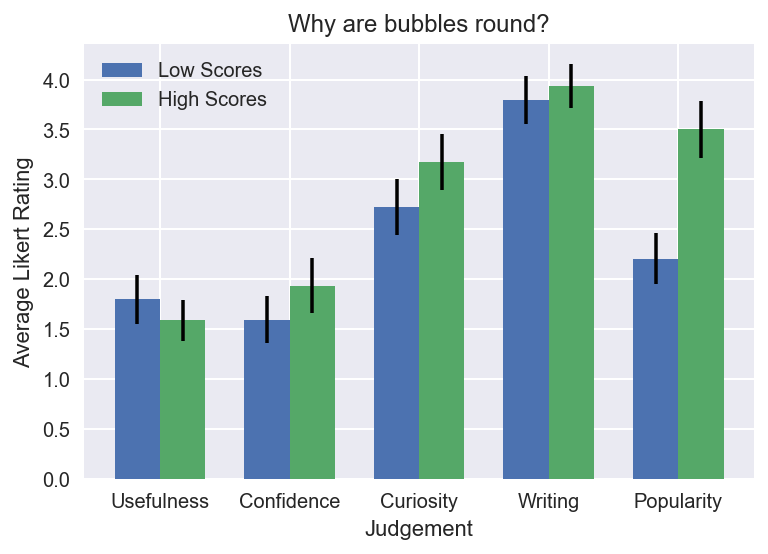

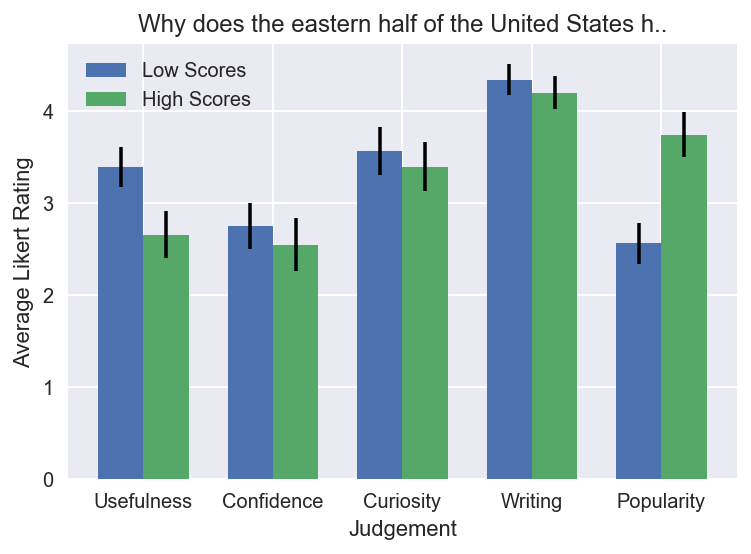

In [129]:
ticks = ['Usefulness', 'Confidence', 'Curiosity', 'Writing', 'Popularity']
legend = ['Low Scores', 'High Scores']
x_label = 'Judgement'
y_label = 'Average Likert Rating'

# Sample Questions
for ques in ('q5', 'q9'):
    fig, ax = plt.subplots()

    labels = [ques + judge for judge in JUDGEMENTS.values()]
    ind, width = np.arange(len(labels)), 0.35

    a_means = [high_a[column].mean() for column in labels]
    a_stds = [high_a[column].std() / math.sqrt(a_size) for column in labels]
    a_rects = ax.bar(ind, a_means, width, yerr=a_stds)

    b_means = [high_b[column].mean() for column in labels]
    b_stds = [high_b[column].std() / math.sqrt(b_size) for column in labels]
    b_rects = ax.bar(ind + width, b_means, width, yerr=b_stds)

    text = CODES[ques]
    plt.title(text[:48] + '..' if len(text) > 50 else text)

    # fig.set_size_inches(10, 5)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(ticks)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(legend)
    # plt.savefig(ques + '.pdf', bbox_inches='tight')
    plt.show()